# Movie Industry Analysis

Authors: Cayke Felipe dos Anjos, Dolgor Purbueva

<img src="images/screen.png" alt="Alt text" width="1000"/>

## Overview  
This project analyzes past movies data to offer strategic business recommendations for a new film studio. We aim to predict the most profitable strategies for film production and release by examining production budgets, gross revenues, net profits, genres, popularity, key staff and release timelines. As result this project provides three business recommendations: what genre should a future movie be, what budget to allocate and when to release it.

## Business Problem

The company is expanding its portfolio by investing in a new film studio. Launching a film studio in today's competitive entertainment industry requires a solid understanding of what drives movie success and attracts audiences. The movie industry is known for its substantial risks and high capital demands. Recent developments in AI have made video content creation faster and more efficient, increasing competition but also opening up new opportunities to enter the market.

Our project aims to analyze various datasets, including past movies' financial results, genre correlations, and movie ratings and popularity. By using data analysis techniques, we seek to gain valuable insights and identify patterns that can help shape the company's film production strategy. The goal is to provide three concrete business recommendations that maximize profitability and lower business risks, ensuring a strong entry into the market.

Questions we tried to answer with analysis:
* How should the movie be budgeted?
* What genres are most profitable?
* When should a movie be released?

## Data Understanding

We used datasets from Rotten Tomatoes, TheMovieDB, Bom Office Mojo, IMDB and The Numbers. Each dataset is of different size and contains different data catecories which might be seen as a limitation. For every question we answer we choose the most relevant dataset or merge some of them together for a fuller picture.

For budget related analysis we used IMDB and The Numbers. TheMovieDD dataset was used to explore movie ratings and popularity.

* One of the main metrics we explored is genre. [IMDB defines](https://help.imdb.com/article/contribution/titles/genres/GZDRMS6R742JRGAG?ref_=helpms_h#) genre as a category of artistic composition, characterized by similarities in form, style, or subject matter for a piece of content. [Reaserch by Mustafa Mahmoud Yousry](https://offscreen.com/view/going_to_the_movies) has shown that genre is the main decision factor for audience when chosing a movie to watch.

<img src="images/genre.png" alt="Alt text" width="400"/>

* We introduced the Return on Investment (ROI) metric as a standardized criterion to measure the financial success of a movie relative to its investments, as well as calculated movie net profit.

* We calculated Net Profit.

<img src="images/screen1.png" alt="Alt text" width="800"/>

<img src="images/movie_data_erd.jpeg" alt="Alt text" width="400"/>

## Data Analysis

In [183]:
import pandas as pd
import numpy as np
import sqlite3
from scipy import stats
import matplotlib.pyplot as plt
from math import ceil, floor
import seaborn as sns

In [184]:
#function for cleaning columns and coverting to integer
def clean_and_convert_to_int(column):
    return column.replace({'\$': '', ',': ''}, regex=True).astype(int)

#function for converting to date type
def convert_to_date(column):
    return pd.to_datetime(column, errors='coerce')

#function to clean object columns
def clean_object(column):
    return column.strip().lower()

### The Numbers DF - Gross and ROI

We have 5782 rows with no Null values.

We convert all money columns into integer, convert release date to date type.

We noticed that ID column is not a unique values, all ID numbers repeat 58 or 57 times. the system doesnt make sense, so we delete id column.

We calculate ROI and Net Profit in new columns. 
Some of the budget and gross values had 0 values. So we drop them using ROI column and lose 367 rows.

**Result: 3611 rows × 6 columns**

In [282]:
#Cleaning The Numbers DF
tn = pd.read_csv('data/tn.movie_budgets.csv')

#Converting strings to int values. Ex: '$1922819' -> 1922819
tn[['production_budget', 'domestic_gross', 'worldwide_gross']] = tn[['production_budget', 'domestic_gross', 'worldwide_gross']].apply(clean_and_convert_to_int)

#Getting release date in timestamp format to get the year
tn[['release_date']] = tn[['release_date']].apply(convert_to_date)
tn['release_year'] = tn['release_date'].dt.year

#id is an internal identifier
tn = tn.drop(columns=['id'])

#Calculating Net Profit. We only regards international success. A lot of movies have huge budgets and only become profitable internationally
tn['worldwide_net'] = tn['worldwide_gross'] - tn['production_budget']

#Calculating Return Over Investment
tn['ROI'] = (tn['worldwide_net']) / tn['production_budget']

tn = tn[(tn['domestic_gross'] != 0) & (tn['worldwide_gross'] != 0)]
tn = tn[(tn['ROI'] != 0) & (tn['ROI'] != np.inf) & (tn['ROI'] != -np.inf) & (tn['ROI'] != -100)]
tn = tn.sort_values(by='ROI')

tn

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
2152,1997-08-24,The Grimm Brothers' Snow White,26000000,5000,5000,1997,-25995000,-0.999808
5027,1993-01-01,Ed and his Dead Mother,1800000,673,673,1993,-1799327,-0.999626
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
...,...,...,...,...,...,...,...,...
5406,1999-07-14,The Blair Witch Project,600000,140539099,248300000,1999,247700000,412.833333
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740
5492,2009-09-25,Paranormal Activity,450000,107918810,194183034,2009,193733034,430.517853
5613,1980-03-21,Mad Max,200000,8750000,99750000,1980,99550000,497.750000


In [284]:
# Correlation between Worldwide Net Profit and Production Budget
column_1 = tn["worldwide_net"]
column_2 = tn["production_budget"]

correlation = column_1.corr(column_2)
print(f'Correlation between Worldwide Net Profit and Production Budget is {correlation.round(2)}')

Correlation between Worldwide Net Profit and Production Budget is 0.61


Text(0.5, 1.0, 'Linear Regression of Production vs Worldwide Net Profit')

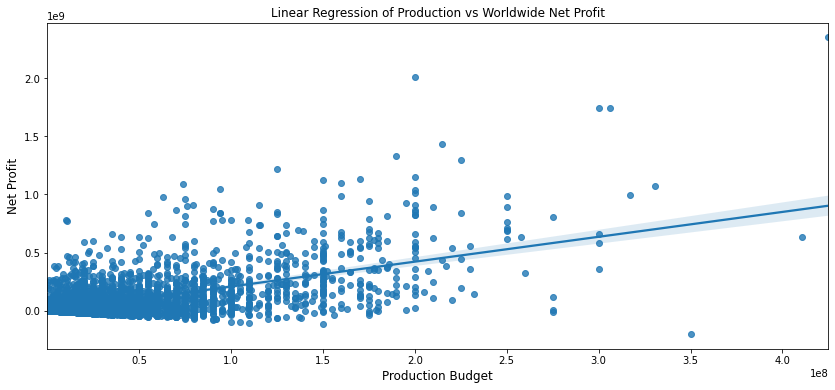

In [285]:
fig, ax = plt.subplots(figsize=(14,6))
sns.regplot(data=tn, x="production_budget", y="worldwide_net", ax=ax)
ax.set_ylabel('Net Profit', fontsize=12)
ax.set_xlabel('Production Budget', fontsize=12)
ax.set_title('Linear Regression of Production vs Worldwide Net Profit')

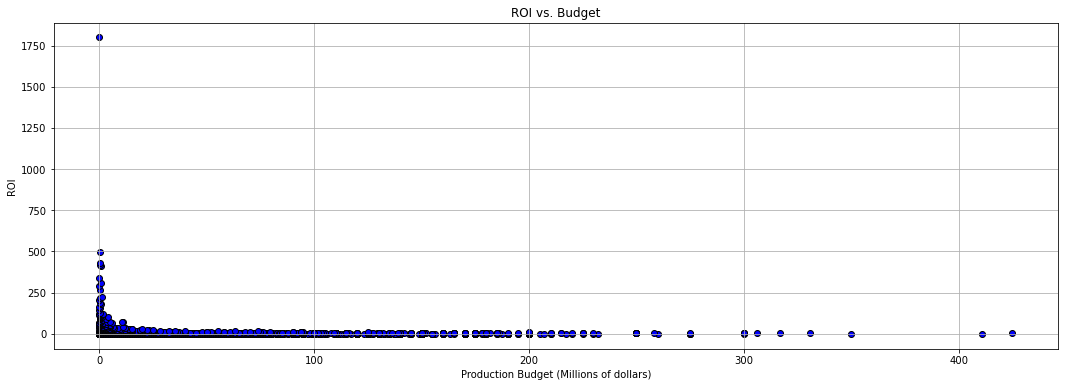

In [283]:
plt.figure(figsize=(18, 6))
plt.scatter(tn['production_budget']/10**6, tn['ROI'], color='blue', edgecolors='black')
plt.title('ROI vs. Budget')
plt.xlabel('Production Budget (Millions of dollars)')
plt.ylabel('ROI')
plt.grid(True)
plt.show()

### IMDB DB

We decided to take region, language and genre info from IMDB db

first we filter by language = en

when trying to filter by region, we see that majority has XWW region (around 18k). so this filtering is irrelevant

I see a lot of confusion between three title columns - primary_title, original_title, title. we stick with primary title

we drop all unnecessary columns and group rows by movie id to avoid duplicates

In [187]:
conn = sqlite3.connect('data/im.db')

df = pd.read_sql(
    """
    SELECT *
    FROM sqlite_master
    """
, conn
)

df[df['type'] == 'table']

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [188]:
conn = sqlite3.connect('data/im.db')

imdb = pd.read_sql(
    """
    SELECT  *
    FROM movie_basics AS mb
    """
, conn
)
imdb

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"
...,...,...,...,...,...,...
146139,tt9916538,Kuambil Lagi Hatiku,Kuambil Lagi Hatiku,2019,123.0,Drama
146140,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,Documentary
146141,tt9916706,Dankyavar Danka,Dankyavar Danka,2013,NaN,Comedy
146142,tt9916730,6 Gunn,6 Gunn,2017,116.0,None


In [189]:
conn = sqlite3.connect('data/im.db')

imdb = pd.read_sql(
    """
    SELECT  mb.primary_title AS movie, 
            mb.start_year, 
            mb.runtime_minutes, 
            mb.genres, 
            per.primary_name AS director
    FROM movie_basics AS mb
    JOIN movie_akas AS ma
    USING(movie_id)
    JOIN directors AS dir
    USING(movie_id)
    JOIN persons AS per
    USING(person_id)
    WHERE language = 'en'
    GROUP BY movie_id
    
    """
, conn
)


### Merged IMDB and TN

In [191]:
merged_df = pd.merge(tn, imdb, on='movie', how='inner')
merged_df.sort_values(by='ROI', ascending=False).reset_index(drop=True)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
0,1978-10-17,Halloween,325000,47000000,70000000,1978,69675000,214.384615,2018,106.0,"Horror,Thriller",David Gordon Green
1,1950-02-15,Cinderella,2900000,85000000,263591415,1950,260691415,89.893591,2015,105.0,"Drama,Family,Fantasy",Kenneth Branagh
2,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,2011,76.0,Drama,Muzaffer Özdemir
3,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,2018,71.0,"Drama,Romance,Thriller",Dario Pleic
4,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,2015,58.0,Documentary,Asaf Lavi Harel
...,...,...,...,...,...,...,...,...,...,...,...,...
771,2014-09-10,Born to Fly: Elizabeth Streb vs. Gravity,500000,1822,1822,2014,-498178,-0.996356,2014,82.0,"Action,Biography,Documentary",Catherine Gund
772,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,2015,92.0,"Comedy,Horror,Sci-Fi",Robbie Pickering
773,2007-03-16,Nomad,40000000,79123,79123,2007,-39920877,-0.998022,2017,NaN,Drama,Emir Mavitan
774,2013-04-05,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,2012,90.0,"Comedy,Horror",Boris Rodriguez


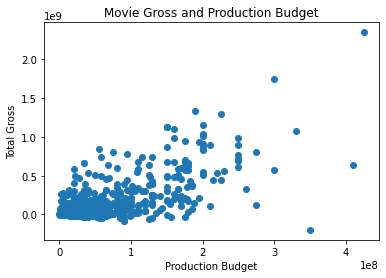

In [192]:
fig, ax = plt.subplots()

ax.set_title('Movie Gross and Production Budget')
ax.set_ylabel('Total Gross')
ax.set_xlabel('Production Budget')

y1 = merged_df.worldwide_net
x1 = merged_df.production_budget

plt.scatter(x1,y1);

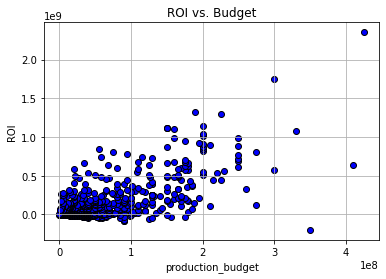

In [193]:
plt.figure()
plt.scatter(merged_df['production_budget'], merged_df['worldwide_net'], color='blue', edgecolors='black')
plt.title('ROI vs. Budget')
plt.xlabel('production_budget')
plt.ylabel('ROI')
plt.grid(True)
plt.show()

In [196]:
merged_df['genres'] = merged_df['genres'].str.split(',')
merged_df_exploded = merged_df.explode('genres')
merged_df_exploded['genres'].value_counts()

Drama          376
Action         231
Comedy         188
Adventure      172
Thriller       152
Crime           97
Romance         75
Sci-Fi          74
Fantasy         72
Horror          71
Mystery         64
Animation       54
Biography       49
Documentary     46
Family          46
History         23
Music           13
War             12
Sport           11
Western          3
Musical          3
News             1
Name: genres, dtype: int64

In [197]:
genres = list(merged_df_exploded['genres'].value_counts().index)

In [198]:
median = merged_df_exploded.groupby('genres')['ROI'].median().reset_index()
median

,genres,ROI
0,Action,1.628946
1,Adventure,2.128847
2,Animation,2.561520
3,Biography,1.226017
4,Comedy,1.380482
5,Crime,1.083232
6,Documentary,0.717537
7,Drama,0.942024
8,Family,1.632850
9,Fantasy,1.648635


In [199]:
median = median.sort_values(by='ROI', ascending=False).reset_index(drop=True)
median

,genres,ROI
0,Horror,3.947870
1,Mystery,3.110214
2,News,2.894215
3,Sci-Fi,2.583173
4,Animation,2.561520
5,Music,2.457024
6,Adventure,2.128847
7,Thriller,1.671211
8,Fantasy,1.648635
9,Family,1.632850


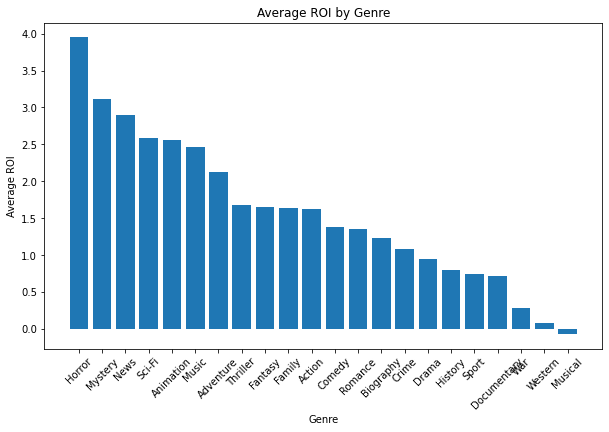

In [200]:
plt.figure(figsize=(10, 6))
plt.bar(median['genres'], median['ROI'])
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.title('Average ROI by Genre')
plt.xticks(rotation=45)
plt.show()

### The Subgenre

In [201]:
merged_df_noNA = merged_df[~merged_df['genres'].isna()]
merged_df_horror = merged_df_noNA[['Horror' in x for x in merged_df_noNA['genres']]]
merged_df_horror

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
1,2013-04-05,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,2012,90.0,"[Comedy, Horror]",Boris Rodriguez
3,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,2015,92.0,"[Comedy, Horror, Sci-Fi]",Robbie Pickering
46,2017-04-21,The Promise,90000000,8224288,10551417,2017,-79448583,-0.882762,2017,114.0,"[Drama, Horror, Thriller]",Sophon Sakdaphisit
58,1999-03-19,Ravenous,12000000,2062406,2062406,1999,-9937594,-0.828133,2017,104.0,"[Drama, Horror, Sci-Fi]",Robin Aubert
84,2018-10-26,Suspiria,20000000,2483472,7034615,2018,-12965385,-0.648269,2018,152.0,"[Fantasy, Horror, Mystery]",Luca Guadagnino
...,...,...,...,...,...,...,...,...,...,...,...,...
771,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,202039844,40.407969,2011,83.0,"[Horror, Mystery, Thriller]",Henry Joost
772,2017-02-24,Get Out,5000000,176040665,255367951,2017,250367951,50.073590,2017,104.0,"[Horror, Mystery, Thriller]",Jordan Peele
773,2017-01-20,Split,5000000,138141585,278964806,2017,273964806,54.792961,2016,117.0,"[Horror, Thriller]",M. Night Shyamalan
774,2010-10-20,Paranormal Activity 2,3000000,84752907,177512032,2010,174512032,58.170677,2010,91.0,[Horror],Tod Williams


In [202]:
merged_df_exploded_horror = merged_df_horror.explode('genres')
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Horror']
merged_df_exploded_horror['genres'].value_counts()

Thriller     34
Mystery      26
Drama        16
Fantasy       9
Action        9
Comedy        6
Sci-Fi        6
Crime         2
Romance       2
Family        1
Animation     1
Adventure     1
Name: genres, dtype: int64

In [203]:
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Family']
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Animation']
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Adventure']
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Crime']
merged_df_exploded_horror = merged_df_exploded_horror[merged_df_exploded_horror['genres']!='Romance']

In [204]:
median_horror = merged_df_exploded_horror.groupby('genres')['ROI'].median().reset_index().sort_values(by='ROI', ascending=False)
median_horror

,genres,ROI
4,Mystery,7.111742
6,Thriller,5.363646
0,Action,3.298994
2,Drama,2.332739
3,Fantasy,0.956445
5,Sci-Fi,0.876500
1,Comedy,0.388101


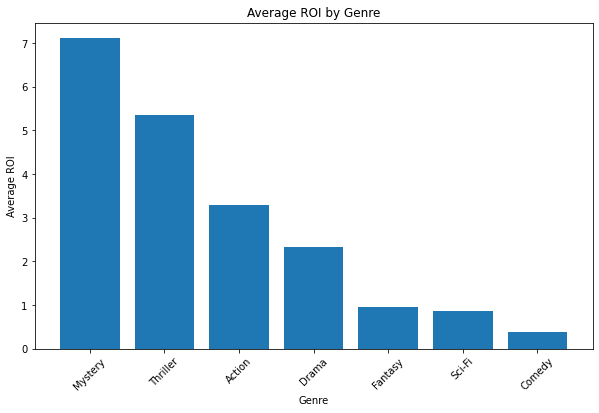

In [205]:
plt.figure(figsize=(10, 6))
plt.bar(median_horror['genres'], median_horror['ROI'])
plt.xlabel('Genre')
plt.ylabel('Average ROI')
plt.title('Average ROI by Genre')
plt.xticks(rotation=45)
plt.show()

## Now things start to get real: getting median to determine high-risk/low risk

We determine the median production budget of a movie since the 2000's in order to split our data set into two tables:
- High risk invetsment, a higher cost that will probably not have a very high ROI but it will grant us a very large profit if audiences enjoy it;
- Low risk investment, a lower cost that can have a high ROI based on the lower investment.

In [206]:
tn_since2000 = tn[pd.to_datetime(tn['release_date']).dt.year>=2000]
tn_since2000

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
5298,2002-12-13,The Jimmy Show,1000000,703,703,2002,-999297,-0.999297
5297,2006-04-21,In Her Line of Fire,1000000,884,884,2006,-999116,-0.999116
...,...,...,...,...,...,...,...,...
5656,2007-05-16,Once,150000,9445857,23323631,2007,23173631,154.490873
5781,2005-08-05,My Date With Drew,1100,181041,181041,2005,179941,163.582727
5709,2004-05-07,Super Size Me,65000,11529368,22233808,2004,22168808,341.058585
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740


In [207]:
# We will work with 2 thresholds for our analysis
budget = tn_since2000['production_budget'].sort_values()
n_budget = len(budget)
threshold_budget_low = budget.iloc[int(n_budget/3)]
threshold_budget_high = budget.iloc[int(2*n_budget/3)]
threshold_budget_low,threshold_budget_high

(11500000, 36000000)

In [208]:
tn_low_risk  = tn_since2000[tn_since2000['production_budget']<=threshold_budget_low]
tn_medium_risk = tn_since2000[(tn_since2000['production_budget']>threshold_budget_low) & (tn_since2000['production_budget']<threshold_budget_high)]
tn_high_risk = tn_since2000[tn_since2000['production_budget']>=threshold_budget_high]

0.611615 15.943401 85.08081


Text(335, 100, 'High Hisk Median Profit (~$85 Million)')

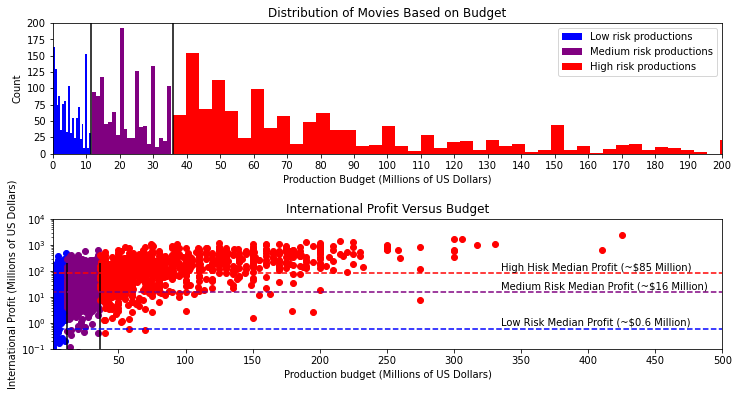

In [209]:
fig, ax = plt.subplots(nrows=2, figsize=(12,6), gridspec_kw={'hspace': 0.5})
# fig.tight_layout()


median_profit_low = tn_low_risk['worldwide_net'].median()/10**6
median_profit_medium = tn_medium_risk['worldwide_net'].median()/10**6
median_profit_high = tn_high_risk['worldwide_net'].median()/10**6
print(median_profit_low, median_profit_medium, median_profit_high)

ax[0].hist(tn_low_risk['production_budget']/10**6, color='b',bins=20, label='Low risk productions')
ax[0].hist(tn_medium_risk['production_budget']/10**6, color='purple',bins=20, label='Medium risk productions')
ax[0].hist(tn_high_risk['production_budget']/10**6, color='r',bins=100, label='High risk productions');
ax[0].set_yticks(np.arange(0,201,25))
ax[0].set_ylim(0,200)
ax[0].set_xticks(np.arange(0,501,10))
ax[0].set_xlim(0,200)
ax[0].set_xlabel('Production Budget (Millions of US Dollars)')
ax[0].set_ylabel('Count')
ax[0].legend()
ax[0].set_title('Distribution of Movies Based on Budget')
ax[0].vlines(x=threshold_budget_low/10**6,ymin=0,ymax=200,color='black')
# ax[0].text(x=threshold_budget_low/10**6,y=175,s='Median budget')
ax[0].vlines(x=threshold_budget_high/10**6,ymin=0,ymax=200,color='black')
# ax[0].text(x=threshold_budget_high,y=175,s='Median budget')

ax[1].scatter(x=tn_low_risk['production_budget']/10**6, y=tn_low_risk['worldwide_net']/10**6,color='b',label='Low risk productions')
ax[1].scatter(x=tn_medium_risk['production_budget']/10**6, y=tn_medium_risk['worldwide_net']/10**6,color='purple',label='Medium risk productions')
ax[1].scatter(x=tn_high_risk['production_budget']/10**6, y=tn_high_risk['worldwide_net']/10**6, color='r', label='High risk productions')
ax[1].set_title('International Profit Versus Budget')
ax[1].set_xlabel('Production budget (Millions of US Dollars)')
ax[1].set_ylabel('International Profit (Millions of US Dollars)')
ax[1].set_yticks(np.arange(0,1000,25))
ax[1].set_ylim(0.1,10000)
ax[1].set_xticks(np.arange(0,501,50))
ax[1].set_xlim(1,500)
ax[1].vlines(x=threshold_budget_low/10**6,ymin=0,ymax=200,color='black')
ax[1].vlines(x=threshold_budget_high/10**6,ymin=0,ymax=200,color='black')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_low,color='blue', linestyle='dashed')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_medium,color='purple', linestyle='dashed')
ax[1].hlines(xmin=0,xmax=500,y=median_profit_high,color='red', linestyle='dashed')
ax[1].set_yscale('log')
ax[1].text(x=335,y=0.8,s='Low Risk Median Profit (~$0.6 Million)')
ax[1].text(x=335,y=20,s='Medium Risk Median Profit (~$16 Million)')
ax[1].text(x=335,y=100,s='High Hisk Median Profit (~$85 Million)')

# ax[1].text(x=21,y=2000,s='Median Profit for Low Risk Movie')

# Low risk

In [210]:
tn_low_risk

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
4081,2010-05-21,Perrierâs Bounty,6600000,828,828,2010,-6599172,-0.999875
3818,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862
5298,2002-12-13,The Jimmy Show,1000000,703,703,2002,-999297,-0.999297
5297,2006-04-21,In Her Line of Fire,1000000,884,884,2006,-999116,-0.999116
3728,2009-10-16,Janky Promoters,10000000,9069,9069,2009,-9990931,-0.999093
...,...,...,...,...,...,...,...,...
5656,2007-05-16,Once,150000,9445857,23323631,2007,23173631,154.490873
5781,2005-08-05,My Date With Drew,1100,181041,181041,2005,179941,163.582727
5709,2004-05-07,Super Size Me,65000,11529368,22233808,2004,22168808,341.058585
5679,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740


In [211]:
conn = sqlite3.connect('data/im.db')

imdb = pd.read_sql(
    """
    SELECT  mb.primary_title AS movie,
            mb.start_year, 
            mb.runtime_minutes, 
            mb.genres, 
            per.primary_name AS director
    FROM movie_basics AS mb
    JOIN movie_akas AS ma
    USING(movie_id)
    JOIN directors AS dir
    USING(movie_id)
    JOIN persons AS per
    USING(person_id)
    GROUP BY movie_id
    
    """
, conn
)
imdb

,movie,start_year,runtime_minutes,genres,director
0,Sunghursh,2013,175.0,"Action,Crime,Drama",Harnam Singh Rawail
1,One Day Before the Rainy Season,2019,114.0,"Biography,Drama",Mani Kaul
2,The Other Side of the Wind,2018,122.0,Drama,Orson Welles
3,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",Hrishikesh Mukherjee
4,The Wandering Soap Opera,2017,80.0,"Comedy,Drama,Fantasy",Raoul Ruiz
...,...,...,...,...,...
119436,Padmavyuhathile Abhimanyu,2019,130.0,Drama,Vineesh Aaradya
119437,Nepal - Homebird,2019,52.0,Documentary,Andrea Leichtfried
119438,A Cherry Tale,2019,85.0,Documentary,Eva Mulvad
119439,Vida em Movimento,2019,70.0,Documentary,Eduardo Rajabally


In [212]:
genre_dict = {
    '28': 'Action',
    '12': 'Adventure',
    '16': 'Animation',
    '35': 'Comedy',
    '80': 'Crime',
    '99': 'Documentary',
    '18': 'Drama',
    '10751': 'Family',
    '14': 'Fantasy',
    '36': 'History',
    '27': 'Horror',
    '10402': 'Music',
    '9648': 'Mystery',
    '10749': 'Romance',
    '878': 'Science Fiction',
    '10770': 'TV Movie',
    '53': 'Thriller',
    '10752': 'War',
    '37': 'Western'
}

In [213]:
movie_db = pd.read_csv('data/tmdb.movies.csv')
movie_db['genre_ids'] = movie_db['genre_ids'].replace({'\[': '', '\]': ''}, regex=True)
movie_db['genre_ids'] = movie_db['genre_ids'].str.split(',')
movie_db = movie_db.explode('genre_ids')
movie_db['genre_ids'] = movie_db['genre_ids'].apply(clean_object)
movie_db['genre_ids'] = movie_db['genre_ids'].map(genre_dict)
movie_db.drop(labels=['Unnamed: 0', 'id', 'original_language', 'popularity', 'release_date','vote_average', 'vote_count'],axis=1,inplace=True)
movie_db.rename(columns={'title':'movie','genre_ids':'genres'},inplace=True)
movie_db

,genres,original_title,movie
0,Adventure,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
0,Fantasy,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
0,Family,Harry Potter and the Deathly Hallows: Part 1,Harry Potter and the Deathly Hallows: Part 1
1,Fantasy,How to Train Your Dragon,How to Train Your Dragon
1,Adventure,How to Train Your Dragon,How to Train Your Dragon
...,...,...,...
26515,Family,Trailer Made,Trailer Made
26515,Adventure,Trailer Made,Trailer Made
26515,Action,Trailer Made,Trailer Made
26516,Thriller,The Church,The Church


In [214]:
df_lowrisk_merged1 = pd.merge(tn_low_risk,movie_db,how='inner',on='movie')
df_lowrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_lowrisk_merged1.drop('original_title', axis=1, inplace=True)
df_lowrisk_merged1.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Thriller
1,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Action
2,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Drama
4,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Action
5,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Science Fiction
...,...,...,...,...,...,...,...,...,...
1314,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Horror
1319,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Thriller
1320,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror
1321,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740,Horror


In [215]:
df_lowrisk_merged2 = pd.merge(left=tn_low_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_lowrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_lowrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_lowrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_lowrisk_merged2.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Thriller
1,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Action
2,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Drama
4,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Action
5,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,Science Fiction
...,...,...,...,...,...,...,...,...,...
1296,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Drama
1300,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Thriller
1301,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror
1302,2015-07-10,The Gallows,100000,22764410,41656474,2015,41556474,415.564740,Horror


In [216]:
df_lowrisk_merged3 = pd.merge(tn_low_risk,imdb,how='inner',on='movie')
df_lowrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_lowrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_lowrisk_merged3.dropna(subset=['genres', 'worldwide_net', 'movie','production_budget'],inplace=True)
df_lowrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-05-08,Skin Trade,9000000,1242,1242,2015,-8998758,-0.999862,Documentary
2,2018-05-11,Higher Power,500000,528,528,2018,-499472,-0.998944,"Action,Sci-Fi,Thriller"
3,2013-02-22,Inescapable,4000000,4327,4327,2013,-3995673,-0.998918,"Action,Drama,Mystery"
4,2013-04-05,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,"Comedy,Horror"
5,2012-10-26,The Ghastly Love of Johnny X,2000000,2436,2436,2012,-1997564,-0.998782,"Comedy,Fantasy,Musical"
...,...,...,...,...,...,...,...,...,...
838,2015-04-17,Unfriended,1000000,32789645,64364198,2015,63364198,63.364198,"Horror,Mystery,Thriller"
839,2011-04-01,Insidious,1500000,54009150,99870886,2011,98370886,65.580591,"Horror,Mystery,Thriller"
840,2009-04-23,Home,500000,15433,44793168,2009,44293168,88.586336,Drama
860,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,100759490,100.759490,Horror


In [217]:
df_lowrisk_merged3['genres'] = df_lowrisk_merged3['genres'].str.split(',')
df_lowrisk_merged3 = df_lowrisk_merged3.explode('genres')
# df_lowrisk_merged3['genres'].value_counts()

In [218]:
df_lowrisk_exploded = pd.concat([df_lowrisk_merged1,df_lowrisk_merged2,df_lowrisk_merged3])
df_lowrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_lowrisk_exploded['genres'].value_counts()

Drama              413
Comedy             192
Thriller           176
Horror             127
Romance            113
Mystery             96
Crime               84
Action              67
Documentary         66
Biography           52
Science Fiction     40
Fantasy             36
Music               36
Adventure           34
Family              32
Sci-Fi              28
History             27
War                 16
Sport               13
Animation            9
Western              7
Musical              5
Name: genres, dtype: int64

In [219]:
df_lowrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_lowrisk_exploded['genres'].value_counts()

Drama          413
Comedy         192
Thriller       176
Horror         127
Romance        113
Mystery         96
Crime           84
Sci-Fi          68
Action          67
Documentary     66
Biography       52
Fantasy         36
Music           36
Adventure       34
Family          32
History         27
War             16
Sport           13
Animation        9
Western          7
Musical          5
Name: genres, dtype: int64

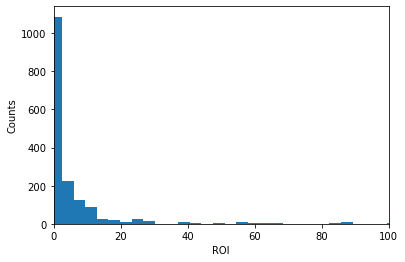

In [220]:
plt.hist(df_lowrisk_exploded['ROI'], bins=120);
plt.xlim(0,100)
plt.xlabel('ROI')
plt.ylabel('Counts');

## Low Risk - Genre

In [221]:
df_lowrisk_exploded.groupby('genres')['ROI'].median().sort_values(ascending=False).reset_index()

,genres,ROI
0,Horror,4.163727
1,Mystery,3.810244
2,Sci-Fi,1.751043
3,Romance,1.036410
4,Thriller,0.999622
5,Fantasy,0.788086
6,Comedy,0.535147
7,Drama,0.345398
8,Music,0.340786
9,Biography,0.284777


In [222]:
df_lowrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index()

,genres,worldwide_net
0,Horror,15434588.0
1,Mystery,14371155.5
2,Romance,2681937.0
3,Fantasy,2438210.0
4,Thriller,1889796.0
5,Biography,1704546.0
6,Comedy,1661282.5
7,Sci-Fi,1631110.5
8,Drama,545420.0
9,Music,446026.0


In [223]:
#Let us calculate the probability that an animation and horror movie will have $50 million, $100 million and $150 million profit
mean_horror = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'].mean()/10**6
std_horror = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'].std()/10**6
n_horror = len(df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Horror']['worldwide_net'])

t_horror_20 = (20-mean_horror)/(std_horror/n_horror**0.5)
t_horror_35 = (35-mean_horror)/(std_horror/n_horror**0.5)
t_horror_50 = (50-mean_horror)/(std_horror/n_horror**0.5)
print(f'T scores for profit of: \n$20 million = {t_horror_20}\n$35 million = {t_horror_35}\n$50 million = {t_horror_50}\n')

prob_horror_20 = 1-stats.t.cdf(t_horror_20,df=n_horror-1)
prob_horror_35 = 1-stats.t.cdf(t_horror_35,df=n_horror-1)
prob_horror_50 = 1-stats.t.cdf(t_horror_50,df=n_horror-1)
print(f'Probability for profit of: \n$20 million = {prob_horror_20}\n$35 million = {prob_horror_35}\n$50 million = {prob_horror_50}')

horror_avg_cost = df_lowrisk_exploded[df_lowrisk_exploded['genres'] == 'Horror']['production_budget'].mean()
print(f'Average cost of horror movies below ${threshold_budget_low/10**6:0.2f} million are ${horror_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -3.6017645678829204
$35 million = -0.6797071532264723
$50 million = 2.242350261429976

Probability for profit of: 
$20 million = 0.9997733937949502
$35 million = 0.7510316219789762
$50 million = 0.013343571801237686
Average cost of horror movies below $11.50 million are $4.51 millions


In [224]:
mean_mystery = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'].mean()/10**6
std_mystery = df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'].std()/10**6
n_mystery = len(df_lowrisk_exploded[df_lowrisk_exploded['genres']=='Mystery']['worldwide_net'])

t_mystery_20 = (20-mean_mystery)/(std_mystery/n_mystery**0.5)
t_mystery_35 = (35-mean_mystery)/(std_mystery/n_mystery**0.5)
t_mystery_50 = (50-mean_mystery)/(std_mystery/n_mystery**0.5)
print(f'T scores for profit of: \n$20 million = {t_mystery_20}\n$35 million = {t_mystery_35}\n$50 million = {t_mystery_50}\n')

prob_mystery_20 = 1-stats.t.cdf(t_mystery_20,df=n_mystery-1)
prob_mystery_35 = 1-stats.t.cdf(t_mystery_35,df=n_mystery-1)
prob_mystery_50 = 1-stats.t.cdf(t_mystery_50,df=n_mystery-1)
print(f'Probability for profit f: \n$20 million = {prob_mystery_20}\n$35 million = {prob_mystery_35}\n$50 million = {prob_mystery_50}')

mystery_avg_cost = df_lowrisk_exploded[df_lowrisk_exploded['genres'] == 'Mystery']['production_budget'].mean()
print(f'Average cost of mystery movies below ${threshold_budget_low/10**6:0.2f} million are ${mystery_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.769851906203676
$35 million = 0.009069978403655641
$50 million = 2.7879918630109874

Probability for profit f: 
$20 million = 0.9966272916473534
$35 million = 0.49639116153943286
$50 million = 0.003203179748977769
Average cost of mystery movies below $11.50 million are $4.97 millions


This means that Horror movies will cost about the same and will have a higher chance of getting more profit.

## Low Risk - Director

In [225]:
df_merged = pd.merge(tn,imdb,how='inner',on='movie')
df_merged.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_merged['genres'] = df_merged['genres'].str.split(',')
df_merged = df_merged.explode(column='genres')
df_horror = df_merged[df_merged['genres']=='Horror']
df_horror = df_horror[df_horror['production_budget']<=threshold_budget_low]
df_horror.sort_values(by='worldwide_net',ascending=False)

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
2911,2017-02-24,Get Out,5000000,176040665,255367951,2017,250367951,50.073590,2017,104.0,Horror,Jordan Peele
2906,2014-10-03,Annabelle,6500000,84273813,256862920,2014,250362920,38.517372,2014,99.0,Horror,John R. Leonetti
2469,2018-10-19,Halloween,10000000,159342015,254900667,2018,244900667,24.490067,2018,106.0,Horror,David Gordon Green
2907,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,202039844,40.407969,2011,83.0,Horror,Henry Joost
2918,2010-10-20,Paranormal Activity 2,3000000,84752907,177512032,2010,174512032,58.170677,2010,91.0,Horror,Tod Williams
...,...,...,...,...,...,...,...,...,...,...,...,...
309,2003-10-03,Wonderland,5500000,1060512,1060512,2003,-4439488,-0.807180,2011,80.0,Horror,Brandon Slagle
346,2009-05-08,Julia,6000000,65108,1365108,2009,-4634892,-0.772482,2014,95.0,Horror,Matthew A. Brown
12,2009-08-14,Grace,5000000,8297,8297,2009,-4991703,-0.998341,2011,98.0,Horror,Rodger Edralin
10,2015-05-15,Area 51,5000000,7556,7556,2015,-4992444,-0.998489,2015,91.0,Horror,Oren Peli


In [226]:
director_horror = df_horror.groupby('director')['worldwide_net'].mean().sort_values(ascending=False).reset_index()
director_horror.head(10)

,director,worldwide_net
0,Jordan Peele,250367951.0
1,John R. Leonetti,250362920.0
2,Tod Williams,174512032.0
3,Henry Joost,169928918.0
4,Adam Robitel,157885588.0
5,David Gordon Green,157287833.5
6,Gil Kenan,111006019.0
7,Dan Trachtenberg,103286422.0
8,William Brent Bell,100759490.0
9,James DeMonaco,99772063.0


In [227]:
df_horror[df_horror['director'].isin(director_horror['director'].loc[:5])].sort_values('director')

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director
2849,2018-01-05,Insidious: The Last Key,10000000,67745330,167885588,2018,157885588,15.788559,2018,103.0,Horror,Adam Robitel
2469,2018-10-19,Halloween,10000000,159342015,254900667,2018,244900667,24.490067,2018,106.0,Horror,David Gordon Green
2470,1978-10-17,Halloween,325000,47000000,70000000,1978,69675000,214.384615,2018,106.0,Horror,David Gordon Green
2889,2012-10-19,Paranormal Activity 4,5000000,53900335,142817992,2012,137817992,27.563598,2012,88.0,Horror,Henry Joost
2907,2011-10-21,Paranormal Activity 3,5000000,104028807,207039844,2011,202039844,40.407969,2011,83.0,Horror,Henry Joost
2906,2014-10-03,Annabelle,6500000,84273813,256862920,2014,250362920,38.517372,2014,99.0,Horror,John R. Leonetti
2911,2017-02-24,Get Out,5000000,176040665,255367951,2017,250367951,50.073590,2017,104.0,Horror,Jordan Peele
2918,2010-10-20,Paranormal Activity 2,3000000,84752907,177512032,2010,174512032,58.170677,2010,91.0,Horror,Tod Williams


### For the animation movie, we recommend the directors:
- Jordan Peele;
- John R. Leonetti.

## Low risk - Release Month

In [228]:
df_horror['release_month'] = pd.to_datetime(df_horror['release_date'], format='%m').dt.month
df_horror.drop('release_date',axis=1,inplace=True)
df_horror.head()

,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,start_year,runtime_minutes,genres,director,release_month
7,Eddie: The Sleepwalking Cannibal,1400000,1632,1632,2013,-1398368,-0.998834,2012,90.0,Horror,Boris Rodriguez,4
10,Area 51,5000000,7556,7556,2015,-4992444,-0.998489,2015,91.0,Horror,Oren Peli,5
12,Grace,5000000,8297,8297,2009,-4991703,-0.998341,2011,98.0,Horror,Rodger Edralin,8
35,Circle,2000000,10024,10024,2010,-1989976,-0.994988,2010,88.0,Horror,Michael W. Watkins,8
51,Blood Feast,1200000,8708,8708,2018,-1191292,-0.992743,2016,90.0,Horror,Marcel Walz,2


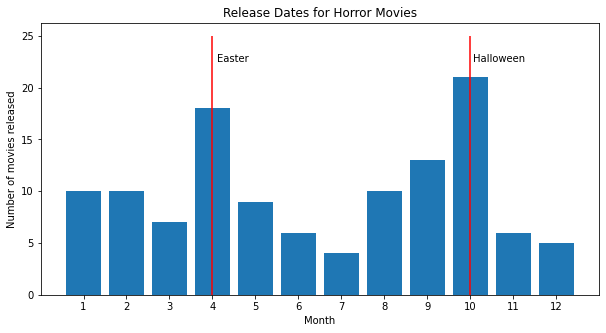

In [229]:
horror_month_release = df_horror.groupby('release_month')['movie'].count().reset_index()

fig,ax = plt.subplots(figsize=(10,5))

ax.bar(x='release_month',height='movie',data=horror_month_release);
ax.set_xticks(np.arange(1,13,1))
ax.set_yticks(np.arange(0,30,5))
ax.set_xlabel('Month')
ax.set_ylabel('Number of movies released');
# ax.vlines(x=2,ymin=0,ymax=18, color='r')
ax.vlines(x=4,ymin=0,ymax=25, color='r')
ax.vlines(x=10,ymin=0,ymax=25, color='r')
# ax.text(x=2.1,y=17, s='Spring Break')
ax.text(x=4.1,y=22.5, s='Easter')
ax.text(x=10.05,y=22.5, s='Halloween')
ax.set_title('Release Dates for Horror Movies');

Two options of release dates.
- April - Easter: a lot of Horror movies have religious subtext;
- November - Halloween.

We recommend releasing the movie during Halloween.

## Low risk - Runtime

In [230]:
n_horror = len(df_horror['runtime_minutes'].dropna())
mean_horror = df_horror['runtime_minutes'].dropna().mean()
std_horror = df_horror['runtime_minutes'].dropna().std()
Tcrit = stats.t.ppf(0.975,n_horror-1)

runtime_horror_low = mean_horror - Tcrit*std_horror/n_horror**0.5
runtime_horror_up = mean_horror + Tcrit*std_horror/n_horror**0.5

print(f'Runtime should be around {round(runtime_horror_low)} to {ceil(runtime_horror_up)} minutes')


Runtime should be around 93.0 to 98 minutes


# Medium Risk

In [231]:
df_mediumrisk_merged1 = pd.merge(tn_medium_risk,movie_db,how='inner',on='movie')
df_mediumrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_mediumrisk_merged1.drop('original_title', axis=1, inplace=True)
df_mediumrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Science Fiction
2,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Comedy
3,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Horror
7,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,Drama
...,...,...,...,...,...,...,...,...,...
1378,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,Romance
1382,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Drama
1383,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Thriller
1384,2014-06-06,The Fault in Our Stars,12000000,124872350,307166834,2014,295166834,24.597236,Romance


In [232]:
df_mediumrisk_merged2 = pd.merge(left=tn_medium_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_mediumrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_mediumrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_mediumrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_mediumrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Science Fiction
2,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Comedy
3,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,Horror
7,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,Drama
...,...,...,...,...,...,...,...,...,...
1329,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,Romance
1333,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Drama
1334,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,Thriller
1335,2014-06-06,The Fault in Our Stars,12000000,124872350,307166834,2014,295166834,24.597236,Romance


In [233]:
df_mediumrisk_merged3 = pd.merge(tn_medium_risk,imdb,how='inner',on='movie')
df_mediumrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_mediumrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_mediumrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2015-11-11,10 Days in a Madhouse,12000000,14616,14616,2015,-11985384,-0.998782,Drama
1,2015-10-30,Freaks of Nature,33000000,70958,70958,2015,-32929042,-0.997850,"Comedy,Horror,Sci-Fi"
2,2013-09-06,Winnie Mandela,15000000,61847,61847,2013,-14938153,-0.995877,"Biography,Drama,History"
3,2015-06-05,United Passions,30000000,918,168832,2015,-29831168,-0.994372,"Drama,History,Sport"
4,2010-06-30,Love Ranch,25000000,137885,146149,2010,-24853851,-0.994154,"Biography,Comedy,Drama"
...,...,...,...,...,...,...,...,...,...
862,2017-09-08,It,35000000,327481748,697457969,2017,662457969,18.927371,"Horror,Thriller"
863,2017-08-11,Annabelle: Creation,15000000,102092201,305384865,2017,290384865,19.358991,"Horror,Mystery,Thriller"
864,2016-12-09,La La Land,20000000,151101803,426351163,2016,406351163,20.317558,"Comedy,Drama,Music"
865,2010-12-03,Black Swan,13000000,106954678,331266710,2010,318266710,24.482055,"Drama,Thriller"


In [234]:
df_mediumrisk_merged3['genres'] = df_mediumrisk_merged3['genres'].str.split(',')
df_mediumrisk_merged3 = df_mediumrisk_merged3.explode('genres')
df_mediumrisk_merged3['genres'].value_counts()

Drama          348
Comedy         191
Action         110
Crime          109
Thriller        96
Romance         94
Biography       69
Horror          55
Adventure       52
Mystery         37
Documentary     35
Sci-Fi          29
Family          27
Fantasy         26
Music           23
History         22
Sport           17
War             14
Animation       11
Western          3
Musical          1
Name: genres, dtype: int64

In [235]:
df_mediumrisk_exploded = pd.concat([df_mediumrisk_merged1, df_mediumrisk_merged2, df_mediumrisk_merged3])
df_mediumrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_mediumrisk_exploded['genres'].value_counts()

Drama              394
Comedy             213
Thriller           183
Crime              132
Action             132
Romance            113
Horror              74
Biography           69
Adventure           65
Mystery             59
History             45
Family              44
Documentary         42
Science Fiction     38
Fantasy             35
Sci-Fi              29
Music               28
War                 24
Sport               17
Animation           16
Western              5
TV Movie             1
Musical              1
Name: genres, dtype: int64

In [236]:
df_mediumrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_mediumrisk_exploded['genres'].value_counts()

Drama          394
Comedy         213
Thriller       183
Crime          132
Action         132
Romance        113
Horror          74
Biography       69
Sci-Fi          67
Adventure       65
Mystery         59
History         45
Family          44
Documentary     42
Fantasy         35
Music           28
War             24
Sport           17
Animation       16
Western          5
TV Movie         1
Musical          1
Name: genres, dtype: int64

## Medium Risk - Genre

In [237]:
df_mediumrisk_exploded.groupby('genres')['worldwide_net'].count().sort_values(ascending=False).reset_index()

,genres,worldwide_net
0,Drama,394
1,Comedy,213
2,Thriller,183
3,Action,132
4,Crime,132
5,Romance,113
6,Horror,74
7,Biography,69
8,Sci-Fi,67
9,Adventure,65


In [238]:
df_mediumrisk_exploded['genres'].replace(to_replace='Musical', value='Music')
df_mediumrisk_exploded = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']!='TV Movie']

In [239]:
df_mediumrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index().head(10)

,genres,worldwide_net
0,Horror,32003693.5
1,Music,29954085.5
2,Comedy,28527161.0
3,Adventure,27427346.0
4,Fantasy,27427346.0
5,Family,27222287.0
6,Romance,26627836.0
7,Documentary,23277674.0
8,Biography,20044909.0
9,Thriller,18293628.0


In [240]:
#Let us calculate the probability that an horror and horror movie will make profits
mean_horror = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'].mean()/10**6
std_horror = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'].std()/10**6
n_horror = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Horror']['worldwide_net'])

t_horror_1 = (20-mean_horror)/(std_horror/n_horror**0.5)
t_horror_2 = (40-mean_horror)/(std_horror/n_horror**0.5)
t_horror_3 = (60-mean_horror)/(std_horror/n_horror**0.5)
t_horror_4 = (80-mean_horror)/(std_horror/n_horror**0.5)
print(f'T scores for profit of: \n$20 million = {t_horror_1}\n$40 million = {t_horror_2}\n$60 million = {t_horror_3}\n$80 million = {t_horror_4}\n')

prob_horror_1 = 1-stats.t.cdf(t_horror_1,df=n_horror-1)
prob_horror_2 = 1-stats.t.cdf(t_horror_2,df=n_horror-1)
prob_horror_3 = 1-stats.t.cdf(t_horror_3,df=n_horror-1)
prob_horror_4 = 1-stats.t.cdf(t_horror_4,df=n_horror-1)
print(f'Probability for profit f: \n$20 million = {prob_horror_1}\n$40 million = {prob_horror_2}\n$60 million = {prob_horror_3}\n$80 million = {prob_horror_4}\n')

horror_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Horror']['production_budget'].mean()
print(f'Average cost of horror movies above $20 million are ${horror_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.98187622485642
$40 million = -1.2232467444970374
$60 million = 0.5353827358623452
$80 million = 2.294012216221728

Probability for profit f: 
$20 million = 0.9980541488043901
$40 million = 0.88741469485021
$60 million = 0.29700627216705655
$80 million = 0.012334480186491636

Average cost of horror movies above $20 million are $22.15 millions


In [241]:
#Let us calculate the probability that an music and music movie will make profits
mean_music = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'].mean()/10**6
std_music = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'].std()/10**6
n_music = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']['worldwide_net'])

t_music_1 = (20-mean_music)/(std_music/n_music**0.5)
t_music_2 = (40-mean_music)/(std_music/n_music**0.5)
t_music_3 = (60-mean_music)/(std_music/n_music**0.5)
t_music_4 = (80-mean_music)/(std_music/n_music**0.5)
print(f'T scores for profit of: \n$20 million = {t_music_1}\n$40 million = {t_music_2}\n$60 million = {t_music_3}\n$80 million = {t_music_4}\n')

prob_music_1 = 1-stats.t.cdf(t_music_1,df=n_music-1)
prob_music_2 = 1-stats.t.cdf(t_music_2,df=n_music-1)
prob_music_3 = 1-stats.t.cdf(t_music_3,df=n_music-1)
prob_music_4 = 1-stats.t.cdf(t_music_4,df=n_music-1)
print(f'Probability for profit f: \n$20 million = {prob_music_1}\n$40 million = {prob_music_2}\n$60 million = {prob_music_3}\n$80 million = {prob_music_4}\n')

music_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Music']['production_budget'].mean()
print(f'Average cost of music movies above $20 million are ${music_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.418205698375475
$40 million = -1.3112389607422235
$60 million = -0.20427222310897178
$80 million = 0.90269451452428

Probability for profit f: 
$20 million = 0.9886917795972838
$40 million = 0.8995902806067388
$60 million = 0.5801636239084736
$80 million = 0.18733560352033518

Average cost of music movies above $20 million are $21.93 millions


In [242]:
#Let us calculate the probability that an comedy and comedy movie will make profits
mean_comedy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'].mean()/10**6
std_comedy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'].std()/10**6
n_comedy = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Comedy']['worldwide_net'])

t_comedy_1 = (20-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_2 = (40-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_3 = (60-mean_comedy)/(std_comedy/n_comedy**0.5)
t_comedy_4 = (80-mean_comedy)/(std_comedy/n_comedy**0.5)
print(f'T scores for profit of: \n$20 million = {t_comedy_1}\n$40 million = {t_comedy_2}\n$60 million = {t_comedy_3}\n$80 million = {t_comedy_4}\n')

prob_comedy_1 = 1-stats.t.cdf(t_comedy_1,df=n_comedy-1)
prob_comedy_2 = 1-stats.t.cdf(t_comedy_2,df=n_comedy-1)
prob_comedy_3 = 1-stats.t.cdf(t_comedy_3,df=n_comedy-1)
prob_comedy_4 = 1-stats.t.cdf(t_comedy_4,df=n_comedy-1)
print(f'Probability for profit f: \n$20 million = {prob_comedy_1}\n$40 million = {prob_comedy_2}\n$60 million = {prob_comedy_3}\n$80 million = {prob_comedy_4}\n')

comedy_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Comedy']['production_budget'].mean()
print(f'Average cost of comedy movies above $20 million are ${comedy_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -5.975203447407423
$40 million = -1.3002000216391634
$60 million = 3.3748034041290964
$80 million = 8.049806829897356

Probability for profit f: 
$20 million = 0.9999999951982208
$40 million = 0.9025279099464543
$60 million = 0.00043918078264115756
$80 million = 2.942091015256665e-14

Average cost of comedy movies above $20 million are $22.78 millions


In [243]:
#Let us calculate the probability that an fantasy and fantasy movie will make profits
mean_fantasy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'].mean()/10**6
std_fantasy = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'].std()/10**6
n_fantasy = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Fantasy']['worldwide_net'])

t_fantasy_1 = (20-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_2 = (40-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_3 = (60-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
t_fantasy_4 = (80-mean_fantasy)/(std_fantasy/n_fantasy**0.5)
print(f'T scores for profit of: \n$20 million = {t_fantasy_1}\n$40 million = {t_fantasy_2}\n$60 million = {t_fantasy_3}\n$80 million = {t_fantasy_4}\n')

prob_fantasy_1 = 1-stats.t.cdf(t_fantasy_1,df=n_fantasy-1)
prob_fantasy_2 = 1-stats.t.cdf(t_fantasy_2,df=n_fantasy-1)
prob_fantasy_3 = 1-stats.t.cdf(t_fantasy_3,df=n_fantasy-1)
prob_fantasy_4 = 1-stats.t.cdf(t_fantasy_4,df=n_fantasy-1)
print(f'Probability for profit f: \n$20 million = {prob_fantasy_1}\n$40 million = {prob_fantasy_2}\n$60 million = {prob_fantasy_3}\n$80 million = {prob_fantasy_4}\n')

fantasy_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Fantasy']['production_budget'].mean()
print(f'Average cost of fantasy movies above $20 million are ${fantasy_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.6459132427948635
$40 million = -0.21811964303040782
$60 million = 2.209673956734048
$80 million = 4.637467556498503

Probability for profit f: 
$20 million = 0.9938754234783517
$40 million = 0.5856801126099807
$60 million = 0.01698172621983829
$80 million = 2.5223421907805132e-05

Average cost of fantasy movies above $20 million are $22.54 millions


In [244]:
#Let us calculate the probability that an adventure and adventure movie will make profits
mean_adventure = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'].mean()/10**6
std_adventure = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'].std()/10**6
n_adventure = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Adventure']['worldwide_net'])

t_adventure_1 = (20-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_2 = (40-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_3 = (60-mean_adventure)/(std_adventure/n_adventure**0.5)
t_adventure_4 = (80-mean_adventure)/(std_adventure/n_adventure**0.5)
print(f'T scores for profit of: \n$20 million = {t_adventure_1}\n$40 million = {t_adventure_2}\n$60 million = {t_adventure_3}\n$80 million = {t_adventure_4}\n')

prob_adventure_1 = 1-stats.t.cdf(t_adventure_1,df=n_adventure-1)
prob_adventure_2 = 1-stats.t.cdf(t_adventure_2,df=n_adventure-1)
prob_adventure_3 = 1-stats.t.cdf(t_adventure_3,df=n_adventure-1)
prob_adventure_4 = 1-stats.t.cdf(t_adventure_4,df=n_adventure-1)
print(f'Probability for profit f: \n$20 million = {prob_adventure_1}\n$40 million = {prob_adventure_2}\n$60 million = {prob_adventure_3}\n$80 million = {prob_adventure_4}\n')

adventure_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Adventure']['production_budget'].mean()
print(f'Average cost of adventure movies above $20 million are ${adventure_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.439442048658327
$40 million = 0.9825688524966413
$60 million = 4.40457975365161
$80 million = 7.826590654806577

Probability for profit f: 
$20 million = 0.991253876712623
$40 million = 0.16475981598027056
$60 million = 2.058929195369874e-05
$80 million = 3.258959768714931e-11

Average cost of adventure movies above $20 million are $25.94 millions


In [245]:
#Let us calculate the probability that an family and family movie will make profits
mean_family = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'].mean()/10**6
std_family = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'].std()/10**6
n_family = len(df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Family']['worldwide_net'])

t_family_1 = (20-mean_family)/(std_family/n_family**0.5)
t_family_2 = (40-mean_family)/(std_family/n_family**0.5)
t_family_3 = (60-mean_family)/(std_family/n_family**0.5)
t_family_4 = (80-mean_family)/(std_family/n_family**0.5)
print(f'T scores for profit of: \n$20 million = {t_family_1}\n$40 million = {t_family_2}\n$60 million = {t_family_3}\n$80 million = {t_family_4}\n')

prob_family_1 = 1-stats.t.cdf(t_family_1,df=n_family-1)
prob_family_2 = 1-stats.t.cdf(t_family_2,df=n_family-1)
prob_family_3 = 1-stats.t.cdf(t_family_3,df=n_family-1)
prob_family_4 = 1-stats.t.cdf(t_family_4,df=n_family-1)
print(f'Probability for profit f: \n$20 million = {prob_family_1}\n$40 million = {prob_family_2}\n$60 million = {prob_family_3}\n$80 million = {prob_family_4}\n')

family_avg_cost = df_mediumrisk_exploded[df_mediumrisk_exploded['genres'] == 'Family']['production_budget'].mean()
print(f'Average cost of family movies above $20 million are ${family_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$20 million = -2.561640089191682
$40 million = 0.019484380665674456
$60 million = 2.6006088505230314
$80 million = 5.181733320380388

Probability for profit f: 
$20 million = 0.9929966155721592
$40 million = 0.492272414595484
$60 million = 0.0063533113993345935
$80 million = 2.785374063951629e-06

Average cost of family movies above $20 million are $22.77 millions


## Genre for this kind of production will be Music

In [246]:
df_music_movies = df_mediumrisk_exploded[df_mediumrisk_exploded['genres']=='Music']
df_music_directors = pd.merge(df_music_movies,imdb,how='inner',on='movie')

In [247]:
df_music_directors.drop_duplicates(subset=['movie','director'],inplace=True)
df_music_directors.drop(['release_date','production_budget','domestic_gross','worldwide_gross','release_year','ROI','genres_x','start_year', 'runtime_minutes','genres_y'],axis=1,inplace=True)
df_music_directors.sort_values('director').sort_values('worldwide_net',ascending=False).head()

,movie,worldwide_net,director
30,La La Land,406351163,Damien Chazelle
20,Pitch Perfect 2,258625468,Elizabeth Banks
18,Straight Outta Compton,174182981,F. Gary Gray
28,Step Up 3D,135889117,Jon M. Chu
16,Step Up Revolution,132552290,Scott Speer


In [248]:
director_count = df_music_directors.groupby('director')['worldwide_net'].count().reset_index().sort_values('worldwide_net',ascending=False)#.iloc[:15]#['director'].iloc[:7]
director_count = director_count.rename(columns={'worldwide_net':'count'})
# director_count = (director_count[director_count['count']>2])
director_count

,director,count
15,Jon M. Chu,2
1,Andrijana Stojkovic,1
28,Todd Graff,1
27,Tate Taylor,1
26,Steven Soderbergh,1
25,Shana Feste,1
24,Scott Speer,1
23,Rachel Lambert,1
22,Princeton Holt,1
21,Nimród Antal,1


In [249]:
df_music_directors.groupby('director').median('worldwide_net').sort_values('worldwide_net', ascending=False)

,worldwide_net
director,
Damien Chazelle,406351163
Elizabeth Banks,258625468
F. Gary Gray,174182981
Scott Speer,132552290
Jon M. Chu,110961621
Gregory Jacobs,109160597
Jason Moore,99044347
Julie Anne Robinson,72678948
Woody Allen,52826015


For lack of data we recommend the director Damien Chazelle, as his Music movie sold 60% more than the second place.

## Medium Risk - Release Date

In [250]:
df_music_movies.head()

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
101,2015-10-23,Rock the Kasbah,15000000,3020665,3386153,2015,-11613847,-0.774256,Music
183,2013-11-27,Black Nativity,17500000,7018188,7285135,2013,-10214865,-0.583707,Music
214,2016-06-03,Popstar: Never Stop Never Stopping,20000000,9496130,9537120,2016,-10462880,-0.523144,Music
356,2013-09-20,Battle of the Year,20000000,8888355,16723377,2013,-3276623,-0.163831,Music
418,2014-08-01,Get on Up,30000000,30569935,33339868,2014,3339868,0.111329,Music


In [251]:
df_music_movies['release_month'] = pd.to_datetime(df_music_movies['release_date'], format='%m').dt.month
music_release_month = df_music_movies.groupby('release_month').count().reset_index()[['release_month','movie']].rename(columns={'movie':'count'})
music_release_month

<ipython-input-251-ec41ebdcb643>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_music_movies['release_month'] = pd.to_datetime(df_music_movies['release_date'], format='%m').dt.month


,release_month,count
0,1,1
1,2,3
2,3,2
3,5,1
4,6,2
5,7,3
6,8,6
7,9,3
8,10,2
9,11,2


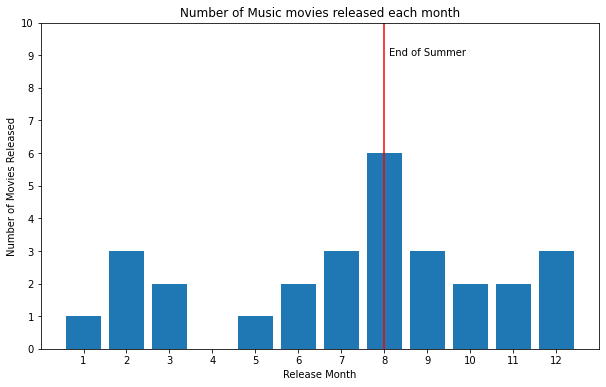

In [252]:
fig,ax = plt.subplots(figsize=(10,6))

ax.bar(x='release_month',height='count', data=music_release_month)
ax.set_xticks(np.arange(1,13))
ax.set_yticks(np.arange(0,11))
ax.set_ylim(0,10)
ax.set_xlabel('Release Month')
ax.set_ylabel('Number of Movies Released')
ax.set_title('Number of Music movies released each month')
ax.vlines(x=8,ymin=0,ymax=40,color='r')
ax.text(x=8.1,y=9,s='End of Summer');

## Medium risk - Runtime

In [253]:
df_music = pd.merge(df_music_movies,imdb,how='inner',on='movie')
df_music.drop_duplicates(subset=['movie'],inplace=True)

runtime_music_mean = df_music['runtime_minutes'].mean()
runtime_music_std = df_music['runtime_minutes'].std()
n_music = len(df_music['runtime_minutes'])
err_music = runtime_music_std/n_music**0.5

Tcrit = stats.t.ppf(0.975,n_music-1)

runtime_music_upper = runtime_music_mean + Tcrit*err_music
runtime_music_lower = runtime_music_mean - Tcrit*err_music

print(f'The duration of the Music movie should be in between {floor(runtime_music_lower)} and {ceil(runtime_music_upper)} minutes.')

The duration of the Music movie should be in between 96 and 113 minutes.


# High risk

In [254]:
tn_high_risk

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI
1242,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521
1536,2007-03-16,Nomad,40000000,79123,79123,2007,-39920877,-0.998022
1535,2004-09-24,The Last Shot,40000000,463730,463730,2004,-39536270,-0.988407
1582,2001-11-30,Texas Rangers,38000000,623374,623374,2001,-37376626,-0.983595
1531,2008-12-12,Delgo,40000000,915840,915840,2008,-39084160,-0.977104
...,...,...,...,...,...,...,...,...
629,2017-06-30,Despicable Me 3,75000000,264624300,1034727750,2017,959727750,12.796370
955,2016-02-12,Deadpool,58000000,363070709,801025593,2016,743025593,12.810786
1377,2015-02-13,Fifty Shades of Grey,40000000,166167230,570998101,2015,530998101,13.274953
672,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219


In [255]:
df_highrisk_merged1 = pd.merge(tn_high_risk,movie_db,how='inner',on='movie')
df_highrisk_merged1.drop_duplicates(subset=['release_date','genres','movie'], inplace=True)
df_highrisk_merged1.drop('original_title', axis=1, inplace=True)
df_highrisk_merged1

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Science Fiction
1,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Drama
2,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Romance
3,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Fantasy
4,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,Drama
...,...,...,...,...,...,...,...,...,...
2001,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Animation
2002,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Adventure
2003,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Comedy
2004,2018-11-02,Bohemian Rhapsody,55000000,216303339,894985342,2018,839985342,15.272461,Drama


In [256]:
df_highrisk_merged2 = pd.merge(left=tn_high_risk, right=movie_db,how='inner',left_on='movie', right_on='original_title')
df_highrisk_merged2.drop_duplicates(subset=['release_date','genres','movie_x'], inplace=True)
df_highrisk_merged2.rename(columns={'movie_x':'movie'},inplace=True)
df_highrisk_merged2.drop(['original_title', 'movie_y'],axis=1,inplace=True)
df_highrisk_merged2

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Science Fiction
1,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Drama
2,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Romance
3,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Fantasy
4,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,Drama
...,...,...,...,...,...,...,...,...,...
1972,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Animation
1973,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Adventure
1974,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,Comedy
1975,2018-11-02,Bohemian Rhapsody,55000000,216303339,894985342,2018,839985342,15.272461,Drama


In [257]:
df_highrisk_merged3 = pd.merge(tn_high_risk,imdb,how='inner',on='movie')
df_highrisk_merged3.drop_duplicates(subset=['release_date','movie'], inplace=True)
df_highrisk_merged3.drop(['runtime_minutes', 'start_year','director'], axis=1, inplace=True)
df_highrisk_merged3

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2007-03-16,Nomad,40000000,79123,79123,2007,-39920877,-0.998022,Drama
3,2004-09-24,The Last Shot,40000000,463730,463730,2004,-39536270,-0.988407,Action
5,2019-06-14,Men in Black: International,110000000,3100000,3100000,2019,-106900000,-0.971818,"Action,Adventure,Comedy"
6,2011-05-06,There Be Dragons,36000000,1069334,4020990,2011,-31979010,-0.888306,"Biography,Drama,War"
7,2017-04-21,The Promise,90000000,8224288,10551417,2017,-79448583,-0.882762,Comedy
...,...,...,...,...,...,...,...,...,...
819,2017-06-30,Despicable Me 3,75000000,264624300,1034727750,2017,959727750,12.796370,"Adventure,Animation,Comedy"
820,2016-02-12,Deadpool,58000000,363070709,801025593,2016,743025593,12.810786,"Action,Adventure,Comedy"
821,2015-02-13,Fifty Shades of Grey,40000000,166167230,570998101,2015,530998101,13.274953,"Drama,Romance,Thriller"
822,2015-07-10,Minions,74000000,336045770,1160336173,2015,1086336173,14.680219,"Adventure,Animation,Comedy"


In [258]:
df_highrisk_merged3['genres'] = df_highrisk_merged3['genres'].str.split(',')
df_highrisk_merged3 = df_highrisk_merged3.explode('genres')
# df_highrisk_merged3['genres'].value_counts()

In [259]:
df_highrisk_exploded = pd.concat([df_highrisk_merged1, df_highrisk_merged2, df_highrisk_merged3])
df_highrisk_exploded.drop_duplicates(subset=['release_date','movie','genres'], inplace=True)
df_highrisk_exploded['genres'].value_counts()

Action             328
Adventure          303
Drama              243
Comedy             229
Thriller           164
Fantasy            149
Family             141
Science Fiction    127
Animation          103
Crime              100
Sci-Fi              86
Romance             61
Mystery             56
Horror              47
Biography           35
History             26
Documentary         23
War                 22
Music               15
Western             10
Sport                9
Musical              5
TV Movie             4
Name: genres, dtype: int64

In [260]:
df_highrisk_exploded['genres'].replace(to_replace='Science Fiction', value='Sci-Fi',inplace=True)
df_highrisk_exploded['genres'].value_counts()

Action         328
Adventure      303
Drama          243
Comedy         229
Sci-Fi         213
Thriller       164
Fantasy        149
Family         141
Animation      103
Crime          100
Romance         61
Mystery         56
Horror          47
Biography       35
History         26
Documentary     23
War             22
Music           15
Western         10
Sport            9
Musical          5
TV Movie         4
Name: genres, dtype: int64

## High risk - Genre

In [261]:
df_highrisk_exploded.groupby('genres')['ROI'].median().sort_values(ascending=False).reset_index().head()

,genres,ROI
0,Animation,1.969215
1,Sci-Fi,1.778310
2,Adventure,1.714085
3,Family,1.671141
4,Biography,1.649823


In [262]:
df_highrisk_exploded.groupby('genres')['worldwide_net'].median().sort_values(ascending=False).reset_index().head()

,genres,worldwide_net
0,Animation,228648063.0
1,Sci-Fi,220098020.0
2,Adventure,179115534.0
3,Family,166562312.0
4,Fantasy,155270083.0


In [263]:
df_highrisk_exploded.groupby('genres')['worldwide_net'].mean().sort_values(ascending=False).reset_index().head()

,genres,worldwide_net
0,Sci-Fi,3.309534e+08
1,Animation,3.071731e+08
2,Adventure,2.908138e+08
3,Family,2.697997e+08
4,Fantasy,2.629255e+08


In [264]:
#Let us calculate the probability that an animation and animation movie will make profits
mean_animation = df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'].mean()/10**6
std_animation = df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'].std()/10**6
n_animation = len(df_highrisk_exploded[df_highrisk_exploded['genres']=='Animation']['worldwide_net'])

t_animation_100 = (100-mean_animation)/(std_animation/n_animation**0.5)
t_animation_200 = (200-mean_animation)/(std_animation/n_animation**0.5)
t_animation_300 = (300-mean_animation)/(std_animation/n_animation**0.5)
t_animation_350 = (350-mean_animation)/(std_animation/n_animation**0.5)
print(f'T scores for profit of: \n$100 million = {t_animation_100}\n$200 million = {t_animation_200}\n$300 million = {t_animation_300}\n$350 million = {t_animation_350}\n')

prob_animation_100 = 1-stats.t.cdf(t_animation_100,df=n_animation-1)
prob_animation_200 = 1-stats.t.cdf(t_animation_200,df=n_animation-1)
prob_animation_300 = 1-stats.t.cdf(t_animation_300,df=n_animation-1)
prob_animation_350 = 1-stats.t.cdf(t_animation_350,df=n_animation-1)
print(f'Probability for profit f: \n$100 million = {prob_animation_100}\n$200 million = {prob_animation_200}\n$300 million = {prob_animation_300}\n$350 million = {prob_animation_350}\n')

animation_avg_cost = df_highrisk_exploded[df_highrisk_exploded['genres'] == 'Animation']['production_budget'].mean()
print(f'Average cost of animation movies above $20 million are ${animation_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$100 million = -6.942394636239825
$200 million = -3.5913826663853423
$300 million = -0.24037069653085955
$350 million = 1.4351352883963817

Probability for profit f: 
$100 million = 0.9999999998168365
$200 million = 0.9997460681006808
$300 million = 0.5947373310370614
$350 million = 0.07715392088809236

Average cost of animation movies above $20 million are $109.87 millions


In [265]:
#Let us calculate the probability that a scifi movie will make profits
mean_scifi = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'].mean()/10**6
std_scifi = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'].std()/10**6
n_scifi = len(df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']['worldwide_net'])

t_scifi_100 = (100-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_200 = (200-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_300 = (300-mean_scifi)/(std_scifi/n_scifi**0.5)
t_scifi_350 = (350-mean_scifi)/(std_scifi/n_scifi**0.5)
print(f'T scores for profit of: \n$100 million = {t_scifi_100}\n$200 million = {t_scifi_200}\n$300 million = {t_scifi_300}\n$350 million = {t_scifi_350}\n')

prob_scifi_100 = 1-stats.t.cdf(t_scifi_100,df=n_scifi-1)
prob_scifi_200 = 1-stats.t.cdf(t_scifi_200,df=n_scifi-1)
prob_scifi_300 = 1-stats.t.cdf(t_scifi_300,df=n_scifi-1)
prob_scifi_350 = 1-stats.t.cdf(t_scifi_350,df=n_scifi-1)
print(f'Probability for profit f: \n$100 million = {prob_scifi_100}\n$200 million = {prob_scifi_200}\n$300 million = {prob_scifi_300}\n$350 million = {prob_scifi_350}\n')

scifi_avg_cost = df_highrisk_exploded[df_highrisk_exploded['genres'] == 'Sci-Fi']['production_budget'].mean()
print(f'Average cost of Sci-Fi movies above $20 million are ${scifi_avg_cost/10**6:.02f} millions')

T scores for profit of: 
$100 million = -9.263001427062184
$200 million = -5.252235667837254
$300 million = -1.241469908612322
$350 million = 0.7639129710001437

Probability for profit f: 
$100 million = 1.0
$200 million = 0.9999998176509557
$300 million = 0.8920979817943602
$350 million = 0.22288422982561462

Average cost of Sci-Fi movies above $20 million are $133.26 millions


## High Risk - Directors

In [266]:
df_scifi_movies = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']
df_scifi_directors = pd.merge(df_scifi_movies,imdb,how='inner',on='movie')
df_scifi_directors

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres_x,start_year,runtime_minutes,genres_y,director
0,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi,2016,104.0,"Action,Adventure,Comedy",Chris Wedge
1,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi,2011,102.0,"Adventure,Comedy,Fantasy",David Gordon Green
2,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2012,109.0,"Drama,Fantasy,Romance",Juan Solanas
3,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2011,NaN,Drama,John Shepphird
4,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,2012,81.0,Drama,Ajay Singh
...,...,...,...,...,...,...,...,...,...,...,...,...,...
258,2005-06-29,War of the Worlds,132000000,234280354,606836535,2005,474836535,3.597246,Sci-Fi,2013,50.0,Sci-Fi,Christopher H. Baum
259,2005-06-29,War of the Worlds,132000000,234280354,606836535,2005,474836535,3.597246,Sci-Fi,2014,7.0,Thriller,Connor Van Looveren-Baines
260,2000-12-15,What Women Want,65000000,182805123,374105123,2000,309105123,4.755463,Sci-Fi,2011,116.0,"Comedy,Romance,Sci-Fi",Daming Chen
261,2019-03-08,Captain Marvel,175000000,426525952,1123061550,2019,948061550,5.417495,Sci-Fi,2019,123.0,"Action,Adventure,Sci-Fi",Ryan Fleck


In [267]:
df_scifi_directors.drop_duplicates(subset=['movie','director'],inplace=True)
df_scifi_directors.drop(['release_date','production_budget','domestic_gross','worldwide_gross','release_year','ROI','genres_x','start_year', 'runtime_minutes','genres_y'],axis=1,inplace=True)
df_scifi_directors.sort_values('director')

,movie,worldwide_net,director
31,Vice,10883171,Adam McKay
4,Upside Down,-23612961,Ajay Singh
38,The Watch,12130045,Akiva Schaffer
71,The Book of Eli,78750817,Albert Hughes
15,Annihilation,-11929085,Alex Garland
...,...,...,...
26,Transcendence,3039258,Wally Pfister
202,Maze Runner: The Scorch Trials,249566162,Wes Ball
145,Home,255997896,Yotam Rozin
125,Man of Steel,442999518,Zack Snyder


In [268]:
director_count = df_scifi_directors.groupby('director')['worldwide_net'].count().reset_index().sort_values('worldwide_net',ascending=False)#.iloc[:15]#['director'].iloc[:7]
director_count = director_count.rename(columns={'worldwide_net':'count'})
director_count = (director_count[director_count['count']>2])
director_count

,director,count
116,Paul W.S. Anderson,3
122,Ridley Scott,3
12,Anthony Russo,3
48,Francis Lawrence,3
103,Michael Bay,3


In [269]:
director_list = list(director_count['director'])
director_list

['Paul W.S. Anderson',
 'Ridley Scott',
 'Anthony Russo',
 'Francis Lawrence',
 'Michael Bay']

In [270]:
scifi_topdirectors = df_scifi_directors[df_scifi_directors['director'].isin(director_list)].groupby('director')['worldwide_net'].median().reset_index().sort_values('worldwide_net',ascending=False)
scifi_topdirectors.rename(columns={'worldwide_net': 'Median Profit'})
#list_scifi_topdirectors

,director,Median Profit
2,Michael Bay,894039076
0,Anthony Russo,890069413
1,Francis Lawrence,641575131
4,Ridley Scott,277448265
3,Paul W.S. Anderson,238374190


In [271]:
df_scifi_directors[df_scifi_directors['director'].isin(scifi_topdirectors['director'])].sort_values('director')#.drop_duplicates(subset=['movie', 'director'])

,movie,worldwide_net,director
181,Captain America: The Winter Soldier,544401889,Anthony Russo
191,Captain America: Civil War,890069413,Anthony Russo
262,Avengers: Infinity War,1748134200,Anthony Russo
177,The Hunger Games: Mockingjay - Part 2,488986787,Francis Lawrence
219,The Hunger Games: Mockingjay - Part 1,641575131,Francis Lawrence
224,The Hunger Games: Catching Fire,734868047,Francis Lawrence
121,Transformers: The Last Knight,385893340,Michael Bay
211,Transformers: Age of Extinction,894039076,Michael Bay
213,Transformers: Dark of the Moon,928790543,Michael Bay
166,Resident Evil: Retribution,175647629,Paul W.S. Anderson


Our recommendation for top directors are (in order of profit):
- For movies about robots, Michael Bay;
- For movies based on comics, Anthony Russo;
- For movies based on books, Francis Lawrence;

## High Risk - Release Month

In [272]:
df_scifi_movies = df_highrisk_exploded[df_highrisk_exploded['genres']=='Sci-Fi']
df_scifi_movies

,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Sci-Fi
83,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi
97,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi
104,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi
135,2011-10-14,The Thing,38000000,16999934,27573078,2011,-10426922,-0.274393,Sci-Fi
...,...,...,...,...,...,...,...,...,...
792,2015-06-12,Jurassic World,215000000,652270625,1648854864,2015,1433854864,6.669092,Sci-Fi
793,2018-06-22,Jurassic World: Fallen Kingdom,170000000,417719760,1305772799,2018,1135772799,6.681016,Sci-Fi
794,2017-01-27,Resident Evil: The Final Chapter,40000000,26844692,314101190,2017,274101190,6.852530,Sci-Fi
803,2012-03-23,The Hunger Games,80000000,408010692,677923379,2012,597923379,7.474042,Sci-Fi


In [273]:
df_scifi_movies['release_month'] = pd.to_datetime(df_scifi_movies['release_date'], format='%m').dt.month
df_scifi_movies.head()

<ipython-input-273-cf22b19efc2d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_scifi_movies['release_month'] = pd.to_datetime(df_scifi_movies['release_date'], format='%m').dt.month


,release_date,movie,production_budget,domestic_gross,worldwide_gross,release_year,worldwide_net,ROI,genres,release_month
0,2013-11-01,Mr. Nobody,46500000,3622,22254,2013,-46477746,-0.999521,Sci-Fi,11
83,2017-01-13,Monster Trucks,125000000,33370166,61642798,2017,-63357202,-0.506858,Sci-Fi,1
97,2011-04-08,Your Highness,50000000,21596445,26121638,2011,-23878362,-0.477567,Sci-Fi,4
104,2013-03-15,Upside Down,50000000,102118,26387039,2013,-23612961,-0.472259,Sci-Fi,3
135,2011-10-14,The Thing,38000000,16999934,27573078,2011,-10426922,-0.274393,Sci-Fi,10


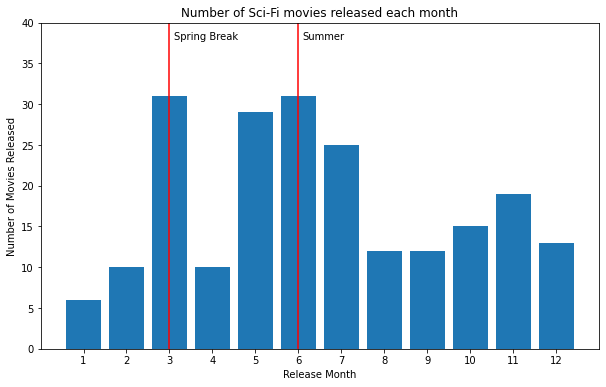

In [274]:
month_count = df_scifi_movies.groupby('release_month').count()['genres'].reset_index().rename(columns={'genres':'count'})

fig,ax = plt.subplots(figsize=(10,6))

ax.bar(x='release_month',height='count', data=month_count)
ax.set_xticks(np.arange(1,13))
ax.set_yticks(np.arange(0,45,5))
ax.set_ylim(0,40)
ax.set_xlabel('Release Month')
ax.set_ylabel('Number of Movies Released')
ax.set_title('Number of Sci-Fi movies released each month')
ax.vlines(x=3,ymin=0,ymax=40,color='r')
ax.vlines(x=6,ymin=0,ymax=40,color='r')
ax.text(x=3.1,y=38,s='Spring Break')
ax.text(x=6.1,y=38,s='Summer');

Movie should be released either in March for Spring Break or in June for Summer.

## High Risk - Runtime

In [275]:
df_scifi = pd.merge(df_scifi_movies,imdb,how='inner',on='movie')
df_scifi.drop_duplicates(subset=['movie'],inplace=True)

runtime_scifi_mean = df_scifi['runtime_minutes'].mean()
runtime_scifi_std = df_scifi['runtime_minutes'].std()
n_scifi = len(df_scifi['runtime_minutes'])
err_scifi = runtime_scifi_std/n_scifi**0.5

Tcrit = stats.t.ppf(0.975,n_scifi-1)

runtime_scifi_upper = runtime_scifi_mean + Tcrit*err_scifi
runtime_scifi_lower = runtime_scifi_mean - Tcrit*err_scifi

print(f'The duration of the Sci-Fi movie should be in between {floor(runtime_scifi_lower)} and {ceil(runtime_scifi_upper)} minutes.')

The duration of the Sci-Fi movie should be in between 115 and 123 minutes.


## Recommendations

**Low Risk:**
* Genre: Horror
* Director: Jordan Peele or John R. Leonetti
* Best release date: Halloween (October) or Easter (April)
* Runtime: 96 to 100 minutes
* Average cost: $7.53 millions

**Medium Risk:**
* Genre: Music
* Director: Damien Chazelle (La La Land)
* Best release date: August
* Runtime: 96 to 113 minutes
* Average cost: $21.93 millions

**High Risk:**
* Genre: Sci-Fi
* Director: Michael Bay (Transformers), 
* Anthony Russo (Marvel), Francis Lawrence (Hunger Games)
* Best release date: March (Spring Break) or June (Summer)
* Runtime: 112 to 120 minutes
* Average cost: $155.73 millions


## Next Steps

For further steps we recommend expanding analysis into several directions:

* Explore data on profits and movie perfomance on streaming services.

* Add budgets spent on marketing. ["Many people get confused when they hear that a movie with a production budget of 100 million grosses 150 million worldwide and loses money. But the brutal fact is that movies get sunk by the massive costs of marketing and distribution all the time."](https://www.studiobinder.com/blog/production-budget/)
